Saved data at iteration 0, total violation is 0
Saved data at iteration 1, total violation is 0
Saved data at iteration 2, total violation is 0
Saved data at iteration 3, total violation is 0
Saved data at iteration 4, total violation is 0
Saved data at iteration 5, total violation is 0
Saved data at iteration 6, total violation is 0
Saved data at iteration 7, total violation is 0
Saved data at iteration 8, total violation is 0
Saved data at iteration 9, total violation is 0
Saved data at iteration 10, total violation is 0
Saved data at iteration 11, total violation is 0
Saved data at iteration 12, total violation is 0
Saved data at iteration 13, total violation is 0
Saved data at iteration 14, total violation is 0
Saved data at iteration 15, total violation is 0
Saved data at iteration 16, total violation is 0
Saved data at iteration 17, total violation is 0
Saved data at iteration 18, total violation is 0
Saved data at iteration 19, total violation is 0
Saved data at iteration 20, to

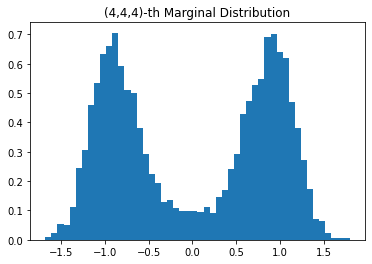

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Given constants
n = 8
d = n**3
h = 1 / (n + 1)
λ = 0.01
β = 1 / 10
dt = 0.002
N = int(1/dt)  # Interested in T = 1
dt = 1/N  # Correct for small deviation

BATCH_SIZE = 100  # Set your desired batch size

data_path = f"./Saved_Data/3D_GZ_data_d_{d}.npz"

# Hyperparameters
hyperparameters = {
    "d": d,
    "h": h,
    "λ": λ,
    "β": β,
    "dt": dt,
    "N": N,
    "BATCH_SIZE": BATCH_SIZE
}

# Create directory if it doesn't exist
if not os.path.exists("./Saved_Data"):
    os.makedirs("./Saved_Data")

# Load existing data or initialize
if os.path.exists(data_path):
    with np.load(data_path) as data:
        all_samples = data['samples']
else:
    all_samples = np.empty((0, n + 2, n + 2, n + 2))

def V_grad_periodic(U):
    """
    Compute the gradient of the potential energy V for a periodic domain.
    
    Args:
    - U (np.ndarray): Input tensor for which the gradient is computed.
    
    Returns:
    - np.ndarray: Gradient of the potential energy V.
    """
    return (λ / h**2) * (
        6*U - np.roll(U, 1, axis=1) - np.roll(U, -1, axis=1) 
        - np.roll(U, -1, axis=2) - np.roll(U, 1, axis=2)
        - np.roll(U, -1, axis=3) - np.roll(U, 1, axis=3)
    ) - np.pi*np.sin(np.pi*U) / (4*λ)

def V_grad(U):
    """
    Compute the gradient of the potential energy V for a periodic domain.
    
    Args:
    - U (np.ndarray): Input tensor for which the gradient is computed.
    
    Returns:
    - np.ndarray: Gradient of the potential energy V.
    """
    return (λ / h**2) * (
        6*U - np.roll(U, 1, axis=1) - np.roll(U, -1, axis=1) 
        - np.roll(U, -1, axis=2) - np.roll(U, 1, axis=2)
        - np.roll(U, -1, axis=3) - np.roll(U, 1, axis=3)
    ) - U * (1 - U**2) /λ

count = 0


for iteration in range(60):

    U = np.zeros((BATCH_SIZE, n + 2, n + 2, n + 2))  # Initialize at each iteration

    # Creating samples for 1D Ginzburg Landau
    for _ in range(N):
        dW = np.sqrt(dt) * np.random.randn(BATCH_SIZE, n + 2, n + 2, n + 2)
        U[:, 1:-1, 1:-1, 1:-1] += (-V_grad(U)[:, 1:-1, 1:-1, 1:-1] * dt + np.sqrt(2/β) * dW[:, 1:-1, 1:-1, 1:-1])
        count += np.sum(U > 2.5) + np.sum(U <-2.5)
        U[U > 2.5] = 2.5
        U[U < -2.5] = -2.5
    all_samples = np.concatenate((all_samples, U), axis=0)
    print(f'Saved data at iteration {iteration}, total violation is {count}')

    # Save the accumulated data
    np.savez(data_path, samples=all_samples, hyperparameters=hyperparameters)

# Visualization of the 8-th marginal distribution
eighth_samples = all_samples[:, 4, 4, 4]  # Extract the 4-th bit from each sample
plt.hist(eighth_samples, bins=50, density=True)
plt.title("(4,4,4)-th Marginal Distribution")
plt.show()


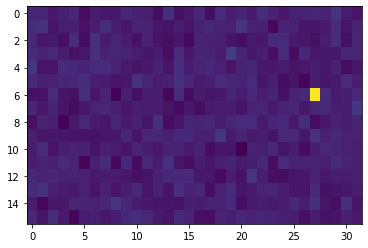

In [17]:
# Calculate two-point correlation
from copy import deepcopy

def int_to_bin(val, length):
    """Convert integer to binary representation with fixed length."""
    return format(val, f'0{length}b')

def interlace_3d(i, j, k, l):
    """Interlace the binary representations of i and j up to length l."""
    i_bin = int_to_bin(i, l)
    j_bin = int_to_bin(j, l)
    k_bin = int_to_bin(k, l)
    interlaced = ''.join([a + b + c for a, b, c in zip(i_bin, j_bin, k_bin)])
    return int(interlaced, 2)

def two_pt_correlation(sample, dim):
    r'''
    Calculate the two pt correlation between target_dimension and every other dimension in the data
    '''
    data_dim = deepcopy(sample[:, dim].reshape(-1, 1))
    data_all = deepcopy(sample)
    data_dim = data_dim - np.mean(data_dim, axis = 0, keepdims = True)
    data_all = data_all - np.mean(data_all, axis = 0, keepdims = True)
    std_all = np.sqrt(np.mean(np.power(data_all, 2), axis = 0))
    std_dim = std_all[dim]
    correlation = 1/data_all.shape[0]*data_all.T@data_dim/(np.outer(std_all, std_dim))

    return correlation
y_3d = all_samples[:, 1:-1, 1:-1, 1:-1]/2.5
col1 = interlace_3d(int(n/2) - 1, int(n/2) - 1, int(n/2) - 1, 3)
true_correlation = np.zeros([n,n,n])
true_correlation_interlaced = two_pt_correlation(y_3d.reshape(y_3d.shape[0], -1), dim=col1)
for i in range(n):
    for j in range(n):
        for k in range(n):
            true_correlation[i, j, k] = true_correlation_interlaced[interlace_3d(i, j, k, l = 3)]

plt.imshow(true_correlation.reshape(16, -1), aspect='auto', cmap='viridis')

In [10]:
all_samples.shape

(1000, 10, 10, 10)

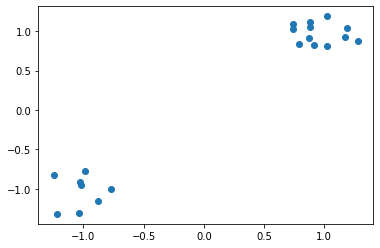

In [38]:
plt.scatter(all_samples[:, 4, 4, 4], all_samples[:, 4, 6, 4])